In [1]:
import os
import tifffile
import numpy as np
import multiprocessing as mp
from tqdm import tqdm_notebook as tqdm
import phathom.phenotype.mesh as mesh
import phathom.phenotype.niche as niche
import matplotlib.pyplot as plt

In [2]:
working_dir = '/media/jswaney/SSD EVO 860/organoid_phenotyping/20181210_eF9_A34_2'

# Load centers and cell-type labels

In [3]:
centers_path = 'centers.npy'
sox2_labels_path = 'sox2_labels.npy'
tbr1_labels_path = 'tbr1_labels.npy'

centers = np.load(os.path.join(working_dir, centers_path))
sox2_labels = np.load(os.path.join(working_dir, sox2_labels_path))
tbr1_labels = np.load(os.path.join(working_dir, tbr1_labels_path))
dn_labels = ~np.logical_or(sox2_labels, tbr1_labels)

centers.shape

(1556799, 3)

In [4]:
voxel_size = (2.052, 1.082, 1.082)

centers_um = mesh.voxels_to_micron(centers, voxel_size)

# Query k-neighbors for each cell type

In [5]:
sox2_centers_um = centers_um[np.where(sox2_labels == 1)[0]]
tbr1_centers_um = centers_um[np.where(tbr1_labels == 1)[0]]
dn_centers_um = centers_um[np.where(dn_labels == 1)[0]]

In [6]:
nbrs_sox2 = niche.fit_neighbors(sox2_centers_um)
nbrs_tbr1 = niche.fit_neighbors(tbr1_centers_um)
nbrs_dn = niche.fit_neighbors(dn_centers_um)

In [7]:
k = 10

sox2_distances, sox2_indices = niche.query_kneighbors(nbrs_sox2, 
                                                      centers_um, 
                                                      k)
tbr1_distances, tbr1_indices = niche.query_kneighbors(nbrs_tbr1, 
                                                      centers_um, 
                                                      k)
dn_distances, dn_indices = niche.query_kneighbors(nbrs_dn, 
                                                  centers_um, 
                                                  k)

In [8]:
sox2_dist = sox2_distances.mean(axis=-1)
tbr1_dist = tbr1_distances.mean(axis=-1)
dn_dist = dn_distances.mean(axis=-1)

sox2_dist, tbr1_dist, dn_dist

(array([38.01451834, 30.00159994, 29.76567979, ...,  8.04742432,
        12.66918919, 16.86000553]),
 array([517.26462994, 499.4347312 , 504.4029531 , ..., 110.14613159,
         93.22634545, 119.48225884]),
 array([56.80961602, 63.12191745, 59.52194912, ..., 21.57511924,
        18.45987245, 16.80147212]))

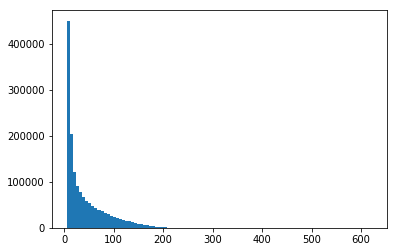

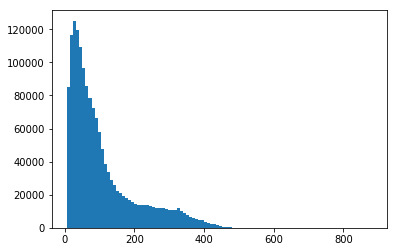

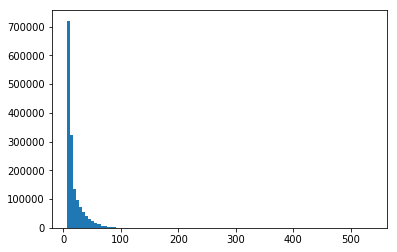

In [9]:
plt.hist(sox2_dist, bins=100)
plt.show()

plt.hist(tbr1_dist, bins=100)
plt.show()

plt.hist(dn_dist, bins=100)
plt.show()

In [16]:
sox2_proximity = 1 / (1 + sox2_dist/10)
tbr1_proximity = 1 / (1 + tbr1_dist/20)
dn_proximity = 1 / (1 + dn_dist/2)

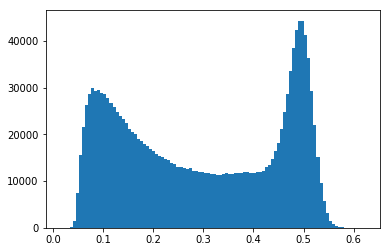

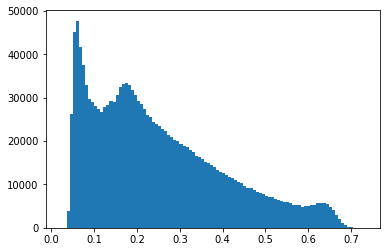

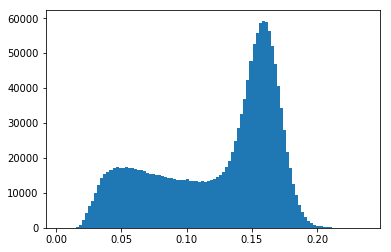

In [17]:
plt.hist(sox2_proximity, bins=100)
plt.show()

plt.hist(tbr1_proximity, bins=100)
plt.show()

plt.hist(dn_proximity, bins=100)
plt.show()

In [19]:
X = np.vstack([sox2_dist, tbr1_dist, dn_dist]).T
X.shape

(1556799, 3)

In [18]:
from sklearn.preprocessing import scale

In [19]:
X_scaled = scale(X)

In [21]:
from sklearn.mixture import GaussianMixture

In [37]:
n_components = 3

y = GaussianMixture(n_components=n_components,
                   ).fit_predict(X)
y.shape

(1556799,)

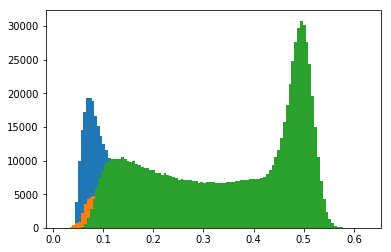

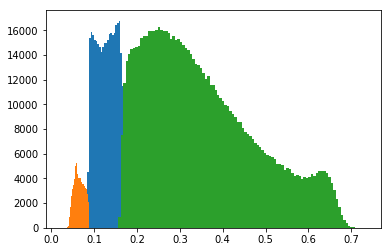

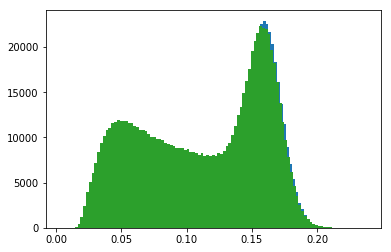

In [61]:
for lbl in range(n_components):
    plt.hist(sox2_proximity[np.where(y == lbl)[0]], bins=100)
plt.show()

for lbl in range(n_components):
    plt.hist(tbr1_proximity[np.where(y == lbl)[0]], bins=100)
plt.show()

for lbl in range(n_components):
    plt.hist(dn_proximity[np.where(y == lbl)[0]], bins=100)
plt.show()

In [39]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [40]:
np.random.seed(1)
(X_sample,), sample_idx = mesh.randomly_sample(5000, X, return_idx=True)

X_tsne = TSNE(2, n_jobs=-1).fit_transform(X_sample)
X_tsne.shape

(5000, 2)

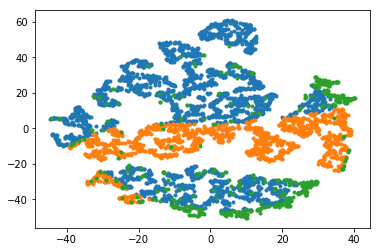

In [41]:
for lbl in range(n_components):
    idx = np.where(y[sample_idx] == lbl)[0]
    plt.plot(X_tsne[idx, 0], X_tsne[idx, 1], '.')
plt.show()

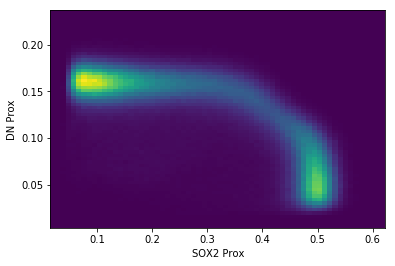

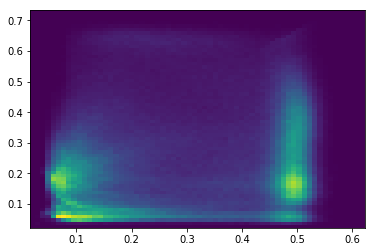

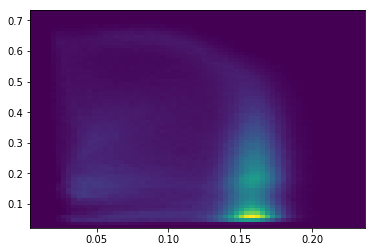

In [42]:
plt.hist2d(sox2_proximity, dn_proximity, bins=64)
plt.xlabel('SOX2 Prox')
plt.ylabel('DN Prox')
plt.show()

plt.hist2d(sox2_proximity, tbr1_proximity, bins=64)
plt.show()

plt.hist2d(dn_proximity, tbr1_proximity, bins=64)
plt.show()